# Perfect competition

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import support_functions as sf
#main model classses
from market import Market
from bank import Bank
from customer_group import Customer_group

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


# Variables

In [2]:
### Simulation settings ###
time_steps = 100

### Market setting ###
score_range = [300,850]
repay_score = 75
default_score = -150

#this correspends to selection rate(perfect competition [0,1])
plane_range = [0, 1]
plane_slice_step = 0.01

#initial interest rate setting
initial_interest_rate_range = [0.15, 0.1]

#demand and supply interest rate boundaries
max_interest_rate_range = [0.3, 0.2]
min_interest_rate_range = [0.03, 0.02]

#policy
selected_policy = 0  #0=MU, 1=DP , 2=EO 
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

### Bank setting ###
bank_line_style = ['-.']
bank_color = ['blue']
#number of banks in the market
N_banks = 21

#bank score distribution shift(same number of shifts as banks)
score_shifts = [0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# profit and impact for banks (same for every bank, but different profit and impact can be set for each bank and model different revenue/cost "function")
utility_repaid = 1
utility_default = -4

### Customer groups setting ###
#use unique names
group_names = ["White","Black"]
group_colors = ['grey', 'black']
group_line_style = ['-',':']

#maximal interest rate which are customers willing to accept
interest_rate_limit = np.inf

#estimated number of customers in each group
white_totals = 8800
black_totals = 1200
loan_demand = 0.1

error_rate = 0.5
score_error = 150

# Prepare initial data

In [3]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals (too many people)
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

#demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customer_scores = sf.get_ref_customers(customer_totals, pis_total, scores_list)

../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


Reference group totals: [8800 1200]
Calculated group totals: [8805 1193]
Group size ratio: [ 0.88067614  0.11932386]


# Create Model

In [4]:
#create market
market = Market(policy_names[selected_policy], policy_colors[selected_policy], score_range = score_range ,repay_score = repay_score, default_score = default_score, max_interest_rate_range = max_interest_rate_range, min_interest_rate_range = min_interest_rate_range, plane_range= plane_range, plane_slice_step = plane_slice_step)

banks= []
for i in range(0,N_banks):
    banks.append(Bank("bank_%02d" % i, bank_color[0],bank_line_style[0], initial_interest_rate_range, market, score_shift=score_shifts[i], utility_repaid=utility_repaid, utility_default = utility_default))

white_group = Customer_group(group_names[0], group_colors[0], group_line_style[0], customer_totals[0], ref_customer_scores[0], loan_demand, 0, 0, market, repays, interest_rate_limit=interest_rate_limit)
black_group = Customer_group(group_names[1], group_colors[1], group_line_style[1], customer_totals[1], ref_customer_scores[1], loan_demand, error_rate, score_error, market, repays, interest_rate_limit=interest_rate_limit)
groups = [white_group, black_group]

### Init model values

In [5]:
for bank in banks:
    market.max_irates[bank.name] = []
    market.min_irates[bank.name] = []
    market.max_irates[bank.name].append(bank.interest_rate_range[0])
    market.min_irates[bank.name].append(bank.interest_rate_range[1])
    
    for group in groups:
        bank.N_loan_curves[group.name] = []
        bank.total_utility_curves[group.name] = []

group_mean_score_change_curve = {}
total_loans = {}
total_utility = {}
for group in groups:      
    group_mean_score_change_curve[group.name] = [0]
    market.loans[group.name] = [0]
    market.utility[group.name] = [0]
    total_loans[group.name] = 0
    total_utility[group.name] = 0

# Next step

In [6]:
for time in range(0, time_steps):
    print("############### STEP "+ str(market.step) + " -> " + str(market.step+1) + " ##################" )
    utilities = {}
    utility_curves = {}
    N_loans = {}
    step_loans = 0
    step_customers = 0
    
    ### Before ###            
    selection_rates, max_util = market.get_selection_rate(banks, groups)
    for bank in banks:
        bank.set_selection_rate(selection_rates[bank.name])
        utilities[bank.name] = {}
        utility_curves[bank.name] = {}
        N_loans[bank.name] = {}

    ### During ###
    for group in groups:
        for bank in banks:
            utilities[bank.name][group.name] = 0
            utility_curves[bank.name][group.name] = []
            N_loans[bank.name][group.name] = 0
            
        #select part of customer base at random according to group loan demand
        customers = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        step_customers += len(customers) 
        #go over all selected customers in the group
        for j in customers:
            selected_bank = None
            bank_select_order = random.sample(range(0, len(banks)), len(banks))
            
            # check banks at random if they give loan to customer j
            for k in bank_select_order:
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    selected_bank = k
                    step_loans += 1
                    total_loans[group.name] += 1
                    break

            if selected_bank is not None:
                #get loan outcome and change score
                N_loans[banks[selected_bank].name][group.name] += 1 
                real_customer_score = group.real_scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_customer_score])
                group.change_score(market, j, loan_outcome)
                group.change_real_score(market, j, loan_outcome)
                
                #get bank utility
                interest_rate = banks[selected_bank].score_interest_rates[group.scores[j]]
                utility_change = banks[selected_bank].get_customer_utility(interest_rate, loan_outcome)
                utilities[banks[selected_bank].name][group.name] += utility_change
                total_utility[group.name] += utility_change
                utility_curves[banks[selected_bank].name][group.name].append(utilities[banks[selected_bank].name][group.name])
        
        for bank in banks:
            if market.step == 0:
                bank.N_loan_curves[group.name].append(N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(utilities[bank.name][group.name])
            else:
                bank.N_loan_curves[group.name].append(bank.N_loan_curves[group.name][-1] + N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(bank.total_utility_curves[group.name][-1] + utilities[bank.name][group.name])        
        group.sort_scores()
        group_mean_score_change_curve[group.name].append(group.get_mean_score_change())
        print(group.name + " group mean score: " + str(group.get_mean_score_change()))
    
    market.step += 1 
    
    ### After ###
    #adjust interest rate, in perfect competition it depends on the total number of people who got a loan.
    total_selection_rate = str(round(step_loans/step_customers,2))
    score_interest_rates = market.interest_rate_plane[total_selection_rate]
    
    for bank in banks:
        bank.change_interest_rate_range(score_interest_rates, market)
        
        market.max_irates[bank.name].append(score_interest_rates[market.score_range[0]])
        market.min_irates[bank.name].append(score_interest_rates[market.score_range[1]])
    
    for group in groups:
        market.loans[group.name].append(total_loans[group.name])
        market.utility[group.name].append(total_utility[group.name])
    print("Selection rate: " + str(total_selection_rate),"Interest_rate:" + str(banks[0].interest_rate_range))
    
    market.plot_market_situation_PC(banks, groups, group_mean_score_change_curve)

############### STEP 0 -> 1 ##################
White group mean score: 3.7777399205
Black group mean score: 1.79966471081
Selection rate: 0.71 Interest_rate:[0.11020000000000001, 0.073469999999999994]
Loans - White: 678, Utility - White: 0.646735545723
Loans - Black: 36, Utility - Black: 0.823944444444
Loans - Total: 714.0, Utility - Total: 0.655670448179

############### STEP 1 -> 2 ##################
White group mean score: 7.7339011925
Black group mean score: 3.26571668064
Selection rate: 0.72 Interest_rate:[0.10752, 0.071679999999999994]
Loans - White: 1366, Utility - White: 0.70018454612
Loans - Black: 68, Utility - Black: 0.794827058824
Loans - Total: 1434.0, Utility - Total: 0.704672475593

############### STEP 2 -> 3 ##################
White group mean score: 11.171266326
Black group mean score: 4.96479463537
Selection rate: 0.68 Interest_rate:[0.11822000000000001, 0.078810000000000005]
Loans - White: 2013, Utility - White: 0.692319056135
Loans - Black: 102, Utility - Black: 0.

############### STEP 23 -> 24 ##################
White group mean score: 61.6805224304
Black group mean score: 22.8616932104
Selection rate: 0.66 Interest_rate:[0.12356, 0.082379999999999995]
Loans - White: 15590, Utility - White: 0.864495242463
Loans - Black: 719, Utility - Black: 0.758029165508
Loans - Total: 16309.0, Utility - Total: 0.859801569685

############### STEP 24 -> 25 ##################
White group mean score: 63.0187393526
Black group mean score: 23.2749371333
Selection rate: 0.65 Interest_rate:[0.12623999999999999, 0.084159999999999999]
Loans - White: 16202, Utility - White: 0.869315056783
Loans - Black: 753, Utility - Black: 0.75249126162
Loans - Total: 16955.0, Utility - Total: 0.864126716013

############### STEP 25 -> 26 ##################
White group mean score: 64.2608745031
Black group mean score: 23.719195306
Selection rate: 0.65 Interest_rate:[0.12623999999999999, 0.084159999999999999]
Loans - White: 16825, Utility - White: 0.874283601783
Loans - Black: 779, Ut

############### STEP 46 -> 47 ##################
White group mean score: 77.9926178308
Black group mean score: 31.2020117351
Selection rate: 0.65 Interest_rate:[0.12623999999999999, 0.084159999999999999]
Loans - White: 29960, Utility - White: 0.93140185247
Loans - Black: 1370, Utility - Black: 0.864746153285
Loans - Total: 31330.0, Utility - Total: 0.928487128311

############### STEP 47 -> 48 ##################
White group mean score: 78.2453151618
Black group mean score: 31.1391450126
Selection rate: 0.67 Interest_rate:[0.12089, 0.080589999999999995]
Loans - White: 30601, Utility - White: 0.933277024607
Loans - Black: 1395, Utility - Black: 0.865037856631
Loans - Total: 31996.0, Utility - Total: 0.930301851481

############### STEP 48 -> 49 ##################
White group mean score: 78.5725156161
Black group mean score: 31.4853310981
Selection rate: 0.65 Interest_rate:[0.12623999999999999, 0.084159999999999999]
Loans - White: 31216, Utility - White: 0.93471875897
Loans - Black: 1429,

############### STEP 69 -> 70 ##################
White group mean score: 81.4824531516
Black group mean score: 32.5775356245
Selection rate: 0.64 Interest_rate:[0.12891, 0.085940000000000003]
Loans - White: 44141, Utility - White: 0.963558540133
Loans - Black: 2037, Utility - Black: 0.911886097202
Loans - Total: 46178.0, Utility - Total: 0.961279169734

############### STEP 70 -> 71 ##################
White group mean score: 81.51641113
Black group mean score: 32.5775356245
Selection rate: 0.64 Interest_rate:[0.12891, 0.085940000000000003]
Loans - White: 44750, Utility - White: 0.964429197989
Loans - Black: 2064, Utility - Black: 0.914162965116
Loans - Total: 46814.0, Utility - Total: 0.962212991199

############### STEP 71 -> 72 ##################
White group mean score: 81.6285065304
Black group mean score: 32.4518021794
Selection rate: 0.65 Interest_rate:[0.12623999999999999, 0.084159999999999999]
Loans - White: 45371, Utility - White: 0.965645550462
Loans - Black: 2089, Utility - B

############### STEP 92 -> 93 ##################
White group mean score: 81.9269733106
Black group mean score: 32.5406538139
Selection rate: 0.63 Interest_rate:[0.13158, 0.087720000000000006]
Loans - White: 58507, Utility - White: 0.981378577264
Loans - Black: 2643, Utility - Black: 0.932113450624
Loans - Total: 61150.0, Utility - Total: 0.979249260343

############### STEP 93 -> 94 ##################
White group mean score: 81.9870528109
Black group mean score: 32.6035205365
Selection rate: 0.63 Interest_rate:[0.13158, 0.087720000000000006]
Loans - White: 59108, Utility - White: 0.982288295662
Loans - Black: 2670, Utility - Black: 0.9336892397
Loans - Total: 61778.0, Utility - Total: 0.980187879989

############### STEP 94 -> 95 ##################
White group mean score: 82.0195343555
Black group mean score: 32.6035205365
Selection rate: 0.66 Interest_rate:[0.12356, 0.082379999999999995]
Loans - White: 59738, Utility - White: 0.983060315711
Loans - Black: 2701, Utility - Black: 0.9354

# Playing with TC, TR, MC, MR and UC

6189
1664.68710276 1100.07321661
1142.352 3215.09376


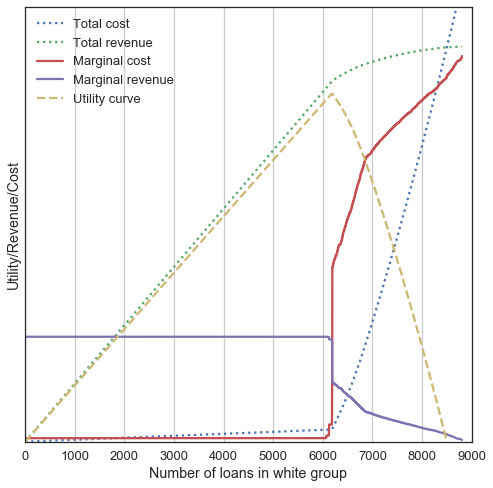

In [7]:
TC_curve = [0]
TR_curve = [0]
MC_curve = []
MR_curve = []
utility_curve = []
TC=0
TR=0
utility=0

n=0

for k in range(0, groups[n].size):
    expected_customer_score = banks[0].get_expected_customer_score(market,groups[n].scores[k])
    utility += banks[0].get_customer_evaluation_utility(expected_customer_score, groups[n])
    utility_curve.append(utility*1)
    TC += -banks[0].utility_default*(1-groups[n].score_repay_prob[expected_customer_score])
    TR += (banks[0].utility_repaid+banks[0].score_interest_rates[expected_customer_score])*groups[n].score_repay_prob[expected_customer_score]
    TC_curve.append(TC)
    TR_curve.append(TR)
    MC_curve.append((TC_curve[-1] - TC_curve[-2])*1800)
    MR_curve.append((TR_curve[-1] - TR_curve[-2])*1800)
    
plt.figure(figsize=(8,8))
plt.plot(list(range(0, len(TC_curve))),TC_curve,LineStyle=":",label="Total cost")
plt.plot(list(range(0, len(TR_curve))),TR_curve,LineStyle=":",label="Total revenue")
plt.plot(list(range(0, len(MC_curve))),MC_curve,label="Marginal cost")
plt.plot(list(range(0, len(MR_curve))),MR_curve,label="Marginal revenue")
plt.plot(list(range(0, len(utility_curve))),utility_curve,LineStyle="--",label="Utility curve")
plt.xlabel("Number of loans in white group")
plt.ylabel("Utility/Revenue/Cost")
plt.ylim(0,8000)
plt.xlim(0,9000)
plt.yticks([])
plt.grid("on")
plt.legend()
plt.show

print(utility_curve.index(max(utility_curve)))
i =utility_curve.index(max(utility_curve))
print(MR_curve[i],MR_curve[i+1])
print(MC_curve[i],MC_curve[i+1])

# Perfect competition market

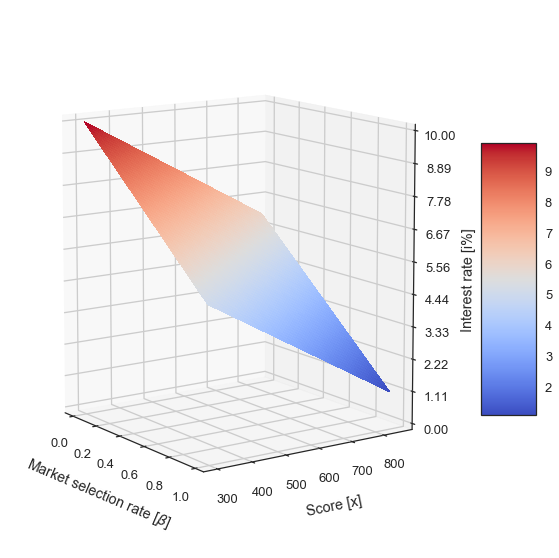

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 1, 0.01)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 5-X*5 + 5-((Y-300)/550)*4 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Market selection rate [$\beta$]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=10., azim=-35)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Imperfect competition cartel market

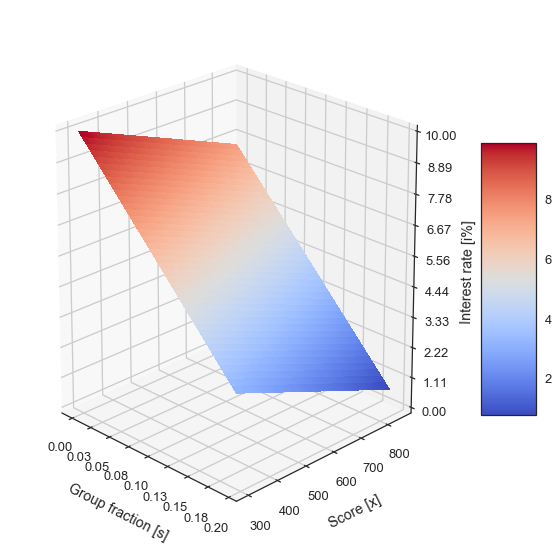

In [9]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 0.2, 0.005)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 7-X*35 + 3 - ((Y-300)/550)*2.5 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Group fraction [s]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=20, azim=-45)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()